# MRI-QC - brainmask
https://mriqc.readthedocs.io/en/latest/docker.html#docker

## Test

In [ ]:
docker run -it nipreps/mriqc:latest --version

## Run the participant level in subjects 001 002 003

If the argument `--participant_label` is not provided, then all subjects will be processed and the group level analysis will automatically be executed without need of running the command in item 3.

Paths `<bids_dir>` and `<output_dir>` must be absolute. In particular, specifying relative paths for `<output_dir>` will generate no error and mriqc will run to completion without error but produce no output.

For security reasons, we recommend to run the docker command with the options `--read-only --tmpfs /run --tmpfs /tmp`. This will run the docker image in read-only mode, and map the temporary folders `/run` and `/tmp` to the temporal folder of the host.

In [ ]:
# default
docker run -it --rm -v <bids_dir>:/data:ro -v <output_dir>:/out nipreps/mriqc:latest /data /out participant --participant_label 001 002 003
# with my paths
docker run -it --rm -v /home/jaimebarranco/Desktop/samples_v3_bids:/data:ro -v /home/jaimebarranco/Desktop/mriqc_output:/out nipreps/mriqc:latest /data /out participant --participant_label 001 002 003
# handle performance
docker run -it --rm -v /home/jaimebarranco/Desktop/samples_v3_bids:/data:ro -v /home/jaimebarranco/Desktop/mriqc_output:/out nipreps/mriqc:latest /data /out participant --participant_label 001 --nprocs 12 --omp-nthreads 12

## Run the group level and report generation on previously processed (use the same `<output_dir>`) subjects

In [ ]:
# default
docker run -it --rm -v <bids_dir>:/data:ro -v <output_dir>:/out nipreps/mriqc:latest /data /out group #--read-only --tmpfs /run --tmpfs /tmp
# with my paths
docker run -it --rm -v /home/jaimebarranco/Desktop/samples_v2_bids:/data:ro -v /home/jaimebarranco/Desktop/mriqc_output:/out nipreps/mriqc:latest /data /out group #--read-only --tmpfs /run --tmpfs /tmp

## Loop of individual participants
And group report

In [ ]:
import os, subprocess

# def run_command(command):
#     process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
#     console_output, console_errors = process.communicate()

def run_command(command):
    os.system(command)

input_folder = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset_bids'
output_folder = '/home/jaimebarranco/Desktop/MRI-QC/mriqc/mriqc_non-labeled-dataset'
n_procs = 12
n_threads = 12

n_sub = [f.path for f in os.scandir(input_folder) if f.is_dir() and f.name.startswith('sub-')] # number of subjects in input folder
n_sub = len(n_sub)
print(f'Number of subjects: {n_sub}')

# Run MRIQC for each subject
for sub in range(n_sub):
    # if sub-xxx_T1w.html exists, skip
    if os.path.isfile(f'{output_folder}/sub-{sub+1:03}_T1w.html'):
        print(f'Subject {sub+1:03} already processed')
        continue
    command = f'docker run --rm -v {input_folder}:/data:ro -v {output_folder}:/out nipreps/mriqc:latest /data /out participant --participant_label {sub+1:03} --nprocs {n_procs} --omp-nthreads {n_threads}'
    print(command)
    run_command(command)

# Run MRIQC group analysis
command = f'docker run --rm -v {input_folder}:/data:ro -v {output_folder}:/out nipreps/mriqc:latest /data /out group'
print(command)
run_command(command)

Check how many .html file reports were generated

In [ ]:
import os

input_folder = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset_bids'
output_folder = '/home/jaimebarranco/Desktop/MRI-QC/mriqc/mriqc_non-labeled-dataset'
n_sub = [f.path for f in os.scandir(input_folder) if f.is_dir() and f.name.startswith('sub-')] # number of subjects in input folder
n_sub = len(n_sub)

# check how many .html files are in output folder
n_html = len([f for f in os.listdir(output_folder) if f.endswith('.html')])
print(f'Number of .html files in output folder: {n_html}')

# which subjects have not been processed (range: 1-1210)
sub_list = [f for f in range(1, n_sub+1) if not os.path.isfile(f'{output_folder}/sub-{f:03}_T1w.html')]
print(f'Subjects not processed ({len(sub_list)}): {sub_list}')

## Metrics correlation - old Meri's scores
Meri's subjective scores vs IQMs (Image Quality Metrics)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# read an excel file in .xlsx format
df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='samples_v3')

# metrics
meri = df['quality'].to_numpy()
cjv = df['cjv'].to_numpy()
cnr = df['cnr'].to_numpy()
efc = df['efc'].to_numpy()
fber = df['fber'].to_numpy()
fwhm_avg = df['fwhm_avg'].to_numpy()
fwhm_x = df['fwhm_x'].to_numpy()
fwhm_y = df['fwhm_y'].to_numpy()
fwhm_z = df['fwhm_z'].to_numpy()
icvs_csf = df['icvs_csf'].to_numpy()
icvs_gm = df['icvs_gm'].to_numpy()
icvs_wm = df['icvs_wm'].to_numpy()
inu_med = df['inu_med'].to_numpy()
inu_range = df['inu_range'].to_numpy()
qi_1 = df['qi_1'].to_numpy()
qi_2 = df['qi_2'].to_numpy()
rpve_csf = df['rpve_csf'].to_numpy()
rpve_gm = df['rpve_gm'].to_numpy()
rpve_wm = df['rpve_wm'].to_numpy()
snr_csf = df['snr_csf'].to_numpy()
snr_gm = df['snr_gm'].to_numpy()
snr_total = df['snr_total'].to_numpy()
snr_wm = df['snr_wm'].to_numpy()
snrd_csf = df['snrd_csf'].to_numpy()
snrd_gm = df['snrd_gm'].to_numpy()
snrd_total = df['snrd_total'].to_numpy()
snrd_wm = df['snrd_wm'].to_numpy()
summary_bg_k = df['summary_bg_k'].to_numpy()
summary_bg_mad = df['summary_bg_mad'].to_numpy()
summary_bg_mean = df['summary_bg_mean'].to_numpy()
summary_bg_median = df['summary_bg_median'].to_numpy()
summary_bg_n = df['summary_bg_n'].to_numpy()
summary_bg_p05 = df['summary_bg_p05'].to_numpy()
summary_bg_p95 = df['summary_bg_p95'].to_numpy()
summary_bg_stdv = df['summary_bg_stdv'].to_numpy()
summary_csf_k = df['summary_csf_k'].to_numpy()
summary_csf_mad = df['summary_csf_mad'].to_numpy()
summary_csf_mean = df['summary_csf_mean'].to_numpy()
summary_csf_median = df['summary_csf_median'].to_numpy()
summary_csf_n = df['summary_csf_n'].to_numpy()
summary_csf_p05 = df['summary_csf_p05'].to_numpy()
summary_csf_p95 = df['summary_csf_p95'].to_numpy()
summary_csf_stdv = df['summary_csf_stdv'].to_numpy()
summary_gm_k = df['summary_gm_k'].to_numpy()
summary_gm_mad = df['summary_gm_mad'].to_numpy()
summary_gm_mean = df['summary_gm_mean'].to_numpy()
summary_gm_median = df['summary_gm_median'].to_numpy()
summary_gm_n = df['summary_gm_n'].to_numpy()
summary_gm_p05 = df['summary_gm_p05'].to_numpy()
summary_gm_p95 = df['summary_gm_p95'].to_numpy()
summary_gm_stdv = df['summary_gm_stdv'].to_numpy()
summary_wm_k = df['summary_wm_k'].to_numpy()
summary_wm_mad = df['summary_wm_mad'].to_numpy()
summary_wm_mean = df['summary_wm_mean'].to_numpy()
summary_wm_median = df['summary_wm_median'].to_numpy()
summary_wm_n = df['summary_wm_n'].to_numpy()
summary_wm_p05 = df['summary_wm_p05'].to_numpy()
summary_wm_p95 = df['summary_wm_p95'].to_numpy()
summary_wm_stdv = df['summary_wm_stdv'].to_numpy()
tpm_overlap_csf = df['tpm_overlap_csf'].to_numpy()
tpm_overlap_gm = df['tpm_overlap_gm'].to_numpy()
tpm_overlap_wm = df['tpm_overlap_wm'].to_numpy()
wm2max = df['wm2max'].to_numpy()

# add all the metrics above to a list
metrics = [meri, cjv, cnr, efc, fber, fwhm_avg, fwhm_x, fwhm_y, fwhm_z, icvs_csf, icvs_gm, icvs_wm, inu_med, inu_range, qi_1, qi_2, rpve_csf, rpve_gm, rpve_wm, snr_csf, snr_gm, snr_total, snr_wm, snrd_csf, snrd_gm, snrd_total, snrd_wm, summary_bg_k, summary_bg_mad, summary_bg_mean, summary_bg_median, summary_bg_n, summary_bg_p05, summary_bg_p95, summary_bg_stdv, summary_csf_k, summary_csf_mad, summary_csf_mean, summary_csf_median, summary_csf_n, summary_csf_p05, summary_csf_p95, summary_csf_stdv, summary_gm_k, summary_gm_mad, summary_gm_mean, summary_gm_median, summary_gm_n, summary_gm_p05, summary_gm_p95, summary_gm_stdv, summary_wm_k, summary_wm_mad, summary_wm_mean, summary_wm_median, summary_wm_n, summary_wm_p05, summary_wm_p95, summary_wm_stdv, tpm_overlap_csf, tpm_overlap_gm, tpm_overlap_wm, wm2max]
metrics_name = [i for i in df.columns if i not in ['subject', 'sub number', 'comments', 'Sex', 'Age', 'Height', 'Weight', 'BMI', 'axial_length']]

ALPHA = 0.05

# correlation between Meri and all the metrics
for i in range(len(metrics)):
    # R-squared measures the proportion of the variance in one variable that is predictable from the other variable.
    # p_value is a measure of the evidence against a null hypothesis. A small p-value indicates strong evidence against the null hypothesis, while a large p-value indicates weak evidence against the null hypothesis 
    r_squared, p_value = stats.pearsonr(meri, metrics[i])
    if p_value < ALPHA:
        print(f'{metrics_name[i]}: r^2 = {r_squared:.4}, p-value = {p_value:.4}')

# plot Meri vs. all the metrics
# for i in range(len(metrics)):
#     plt.figure(figsize=(10, 10))
#     plt.scatter(meri, metrics[i])
#     plt.xlabel('Meri')
#     plt.ylabel(metrics_name[i])
#     plt.show()


## 95% confidence interval: qi_2, summary_bg_mad, summary_gm_mean

In [ ]:
# subjects outside the 95% confidence interval for qi_2
relevant_metrics = [qi_2, summary_bg_mad, summary_gm_mean]
relevant_metrics_name = ['qi_2', 'summary_bg_mad', 'summary_gm_mean']

for i in range(len(relevant_metrics)):
    print(f'\n{relevant_metrics_name[i]}')
    mean = np.mean(relevant_metrics[i])
    std = np.std(relevant_metrics[i])
    lower = mean - 2*std
    upper = mean + 2*std
    print(f'Lower: {lower}, Upper: {upper}')
    for j in range(len(relevant_metrics[i])):
        if relevant_metrics[i][j] < lower or relevant_metrics[i][j] > upper:
            print(f'{j+1:03} - {relevant_metrics[i][j]}')

# Fetal Brain QC (Thomas)

In [ ]:
# usage: qc_list_bids_csv [-h] [--mask-patterns MASK_PATTERNS [MASK_PATTERNS ...]] [--out-csv OUT_CSV] [--anonymize-name | --no-anonymize-name] bids-dir
qc_list_bids_csv --mask-patterns-base /home/jaimebarranco/Desktop/samples_v3_bids/derivatives/masks/ --mask-patterns "sub-{subject}_mask.nii.gz" --out-csv /home/jaimebarranco/Desktop/fetal_qc_output/bids_csv.csv /home/jaimebarranco/Desktop/samples_v3_bids
qc_list_bids_csv --mask-patterns-base /home/jaimebarranco/Desktop/samples_v3_bids/derivatives/masks/ --mask-patterns "sub-{subject}_mask.nii.gz" --out-csv /home/jaimebarranco/Desktop/fetal_qc_output/bids_csv.csv /home/jaimebarranco/Desktop/samples_v3_bids

In [ ]:
qc_run_pipeline --bids_dir /home/jaimebarranco/Desktop/samples_v3_bids --out_path /home/jaimebarranco/Desktop/fetal_qc_output/ --mask-patterns-base /home/jaimebarranco/Desktop/samples_v3_bids/derivatives/masks/ --mask-patterns "_mask.nii.gz"
qc_run_pipeline --bids_dir /home/jaimebarranco/Desktop/samples_v3_bids --out_path /home/jaimebarranco/Desktop/fetal_qc_output/

In [ ]:
# Thomas commands - branch mreye
# being in the data folder
qc_list_bids_csv . --mask-patterns-base derivatives/masks/ --out-csv bids.csv --mask-patterns "sub-{subject}_mask.nii.gz" --suffix T1w # index the folder
qc_generate_reports derivatives/reports bids.csv # generate the reports
# mine
qc_list_bids_csv /home/jaimebarranco/Desktop/samples_v3_bids --mask-patterns-base /home/jaimebarranco/Desktop/samples_v3_bids/derivatives/masks/ --mask-patterns "sub-{subject}_mask.nii.gz" --suffix T1w --out-csv /home/jaimebarranco/Desktop/fetal_qc_output/bids_csv.csv
qc_generate_reports /home/jaimebarranco/Desktop/fetal_qc_output/ /home/jaimebarranco/Desktop/fetal_qc_output/bids_csv.csv # outpath bids.csv
qc_generate_index /home/jaimebarranco/Desktop/fetal_qc_output/ # generate index.html
# test
qc_list_bids_csv /home/jaimebarranco/Desktop/samples_v3_bids_test --mask-patterns-base /home/jaimebarranco/Desktop/samples_v3_bids_test/derivatives/masks/ --mask-patterns "sub-{subject}_mask.nii.gz" --suffix T1w --out-csv /home/jaimebarranco/Desktop/fetal_qc_output_test/bids_csv.csv
qc_generate_reports /home/jaimebarranco/Desktop/fetal_qc_output_test/ /home/jaimebarranco/Desktop/fetal_qc_output_test/bids_csv.csv # outpath bids.csv
# pipeline
qc_run_pipeline --bids_dir /home/jaimebarranco/Desktop/samples_v3_bids --out_path /home/jaimebarranco/Desktop/fetal_qc_output/ --mask-patterns-base /home/jaimebarranco/Desktop/samples_v3_bids/derivatives/masks/ --mask-patterns "sub-{subject}_mask.nii.gz" --suffix T1w

# MREye-QC - brain/eye masks

## Subjective evaluation

In [ ]:
# mreye-qc
docker run -it --rm -v /home/jaimebarranco/Desktop/samples_v3_bids:/data:ro -v /home/jaimebarranco/Desktop/mreyeqc_output:/out mreyeqc:latest /data /out participant --participant_label 001 --nprocs 12 --omp-nthreads 12
# 7bd99c588704826d399898ec1f7419d40dc09b27473d511066f3cf8ab097fe5a

Loop

In [ ]:
import os, subprocess

# def run_command(command):
#     process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
#     console_output, console_errors = process.communicate()

def run_command(command):
    os.system(command)

input_folder = '/home/jaimebarranco/Desktop/samples_v3_bids'
output_folder = '/home/jaimebarranco/Desktop/mreyeqc_output'
n_procs = 12
n_threads = 12

n_sub = [f.path for f in os.scandir(input_folder) if f.is_dir() and f.name.startswith('sub-')] # number of subjects in input folder
n_sub = len(n_sub)
print(f'Number of subjects: {n_sub}')

# Run MRIQC for each subject
for sub in range(1, 6):
    command = f'docker run --rm -v {input_folder}:/data:ro -v {output_folder}:/out mreyeqc_test:latest /data /out participant --participant_label {sub+1:03} --nprocs {n_procs} --omp-nthreads {n_threads}'
    print(command)
    run_command(command)


In [ ]:
# Run MRIQC group analysis
command = f'docker run --rm -v {input_folder}:/data:ro -v {output_folder}:/out mreyeqc_test:latest /data /out group'
print(command)
run_command(command)

Metrics correlation - old Meri's scores

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# read an excel file in .xlsx format
df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='mriqc_eye_mask')

# metrics
meri = df['quality'].to_numpy()
cjv = df['cjv'].to_numpy()
cnr = df['cnr'].to_numpy()
efc = df['efc'].to_numpy()
fber = df['fber'].to_numpy()
fwhm_avg = df['fwhm_avg'].to_numpy()
fwhm_x = df['fwhm_x'].to_numpy()
fwhm_y = df['fwhm_y'].to_numpy()
fwhm_z = df['fwhm_z'].to_numpy()
icvs_csf = df['icvs_csf'].to_numpy()
icvs_gm = df['icvs_gm'].to_numpy()
icvs_wm = df['icvs_wm'].to_numpy()
inu_med = df['inu_med'].to_numpy()
inu_range = df['inu_range'].to_numpy()
qi_1 = df['qi_1'].to_numpy()
qi_2 = df['qi_2'].to_numpy()
rpve_csf = df['rpve_csf'].to_numpy()
rpve_gm = df['rpve_gm'].to_numpy()
rpve_wm = df['rpve_wm'].to_numpy()
snr_csf = df['snr_csf'].to_numpy()
snr_gm = df['snr_gm'].to_numpy()
snr_total = df['snr_total'].to_numpy()
snr_wm = df['snr_wm'].to_numpy()
snrd_csf = df['snrd_csf'].to_numpy()
snrd_gm = df['snrd_gm'].to_numpy()
snrd_total = df['snrd_total'].to_numpy()
snrd_wm = df['snrd_wm'].to_numpy()
summary_bg_k = df['summary_bg_k'].to_numpy()
summary_bg_mad = df['summary_bg_mad'].to_numpy()
summary_bg_mean = df['summary_bg_mean'].to_numpy()
summary_bg_median = df['summary_bg_median'].to_numpy()
summary_bg_n = df['summary_bg_n'].to_numpy()
summary_bg_p05 = df['summary_bg_p05'].to_numpy()
summary_bg_p95 = df['summary_bg_p95'].to_numpy()
summary_bg_stdv = df['summary_bg_stdv'].to_numpy()
summary_csf_k = df['summary_csf_k'].to_numpy()
summary_csf_mad = df['summary_csf_mad'].to_numpy()
summary_csf_mean = df['summary_csf_mean'].to_numpy()
summary_csf_median = df['summary_csf_median'].to_numpy()
summary_csf_n = df['summary_csf_n'].to_numpy()
summary_csf_p05 = df['summary_csf_p05'].to_numpy()
summary_csf_p95 = df['summary_csf_p95'].to_numpy()
summary_csf_stdv = df['summary_csf_stdv'].to_numpy()
summary_gm_k = df['summary_gm_k'].to_numpy()
summary_gm_mad = df['summary_gm_mad'].to_numpy()
summary_gm_mean = df['summary_gm_mean'].to_numpy()
summary_gm_median = df['summary_gm_median'].to_numpy()
summary_gm_n = df['summary_gm_n'].to_numpy()
summary_gm_p05 = df['summary_gm_p05'].to_numpy()
summary_gm_p95 = df['summary_gm_p95'].to_numpy()
summary_gm_stdv = df['summary_gm_stdv'].to_numpy()
summary_wm_k = df['summary_wm_k'].to_numpy()
summary_wm_mad = df['summary_wm_mad'].to_numpy()
summary_wm_mean = df['summary_wm_mean'].to_numpy()
summary_wm_median = df['summary_wm_median'].to_numpy()
summary_wm_n = df['summary_wm_n'].to_numpy()
summary_wm_p05 = df['summary_wm_p05'].to_numpy()
summary_wm_p95 = df['summary_wm_p95'].to_numpy()
summary_wm_stdv = df['summary_wm_stdv'].to_numpy()
tpm_overlap_csf = df['tpm_overlap_csf'].to_numpy()
tpm_overlap_gm = df['tpm_overlap_gm'].to_numpy()
tpm_overlap_wm = df['tpm_overlap_wm'].to_numpy()
wm2max = df['wm2max'].to_numpy()

# add all the metrics above to a list
metrics = [meri, cjv, cnr, efc, fber, fwhm_avg, fwhm_x, fwhm_y, fwhm_z, icvs_csf, icvs_gm, icvs_wm, inu_med, inu_range, qi_1, qi_2, rpve_csf, rpve_gm, rpve_wm, snr_csf, snr_gm, snr_total, snr_wm, snrd_csf, snrd_gm, snrd_total, snrd_wm, summary_bg_k, summary_bg_mad, summary_bg_mean, summary_bg_median, summary_bg_n, summary_bg_p05, summary_bg_p95, summary_bg_stdv, summary_csf_k, summary_csf_mad, summary_csf_mean, summary_csf_median, summary_csf_n, summary_csf_p05, summary_csf_p95, summary_csf_stdv, summary_gm_k, summary_gm_mad, summary_gm_mean, summary_gm_median, summary_gm_n, summary_gm_p05, summary_gm_p95, summary_gm_stdv, summary_wm_k, summary_wm_mad, summary_wm_mean, summary_wm_median, summary_wm_n, summary_wm_p05, summary_wm_p95, summary_wm_stdv, tpm_overlap_csf, tpm_overlap_gm, tpm_overlap_wm, wm2max]
metrics_name = [i for i in df.columns if i not in ['subject', 'sub number', 'comments', 'Sex', 'Age', 'Height', 'Weight', 'BMI', 'axial_length']]

ALPHA = 0.05

# correlation between Meri and all the metrics
for i in range(len(metrics)):
    # R-squared measures the proportion of the variance in one variable that is predictable from the other variable.
    # p_value is a measure of the evidence against a null hypothesis. A small p-value indicates strong evidence against the null hypothesis, while a large p-value indicates weak evidence against the null hypothesis 
    r_squared, p_value = stats.pearsonr(rating, metrics[i])
    if p_value < ALPHA:
        print(f'{metrics_name[i]}: r^2 = {r_squared:.4}, p-value = {p_value:.4}')

# plot Meri vs. all the metrics
# for i in range(len(metrics)):
#     plt.figure(figsize=(10, 10))
#     plt.scatter(meri, metrics[i])
#     plt.xlabel('Meri')
#     plt.ylabel(metrics_name[i])
#     plt.show()


95% confidence interval: snr_csf, summary_csf_mean, summary_wm_mad

In [ ]:
# subjects outside the 95% confidence interval for qi_2
relevant_metrics = [snr_csf, summary_csf_mean, summary_wm_mad]
relevant_metrics_name = ['snr_csf', 'summary_csf_mean', 'summary_wm_mad']

for i in range(len(relevant_metrics)):
    print(f'\n{relevant_metrics_name[i]}')
    mean = np.mean(relevant_metrics[i])
    std = np.std(relevant_metrics[i])
    lower = mean - 2*std
    upper = mean + 2*std
    print(f'Lower: {lower}, Upper: {upper}')
    for j in range(len(relevant_metrics[i])):
        if relevant_metrics[i][j] < lower or relevant_metrics[i][j] > upper:
            print(f'{j+1:03} - {relevant_metrics[i][j]}')

Correlation Meri - Bene

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# read an excel file in .xlsx format
df_meri = pd.read_csv('/home/jaimebarranco/Desktop/SHIP_QCmri_MBC/ratings.csv')
df_bene = pd.read_csv('/home/jaimebarranco/Desktop/Evaluations_frb/ratings.csv')

# metrics meri
rating_meri = df_meri['rating'].to_numpy()
blur_meri = df_meri['blur'].to_numpy()
noise_meri = df_meri['noise'].to_numpy()
motion_meri = df_meri['motion'].to_numpy()
bgair_meri = df_meri['bgair'].to_numpy()
eyes_closed_meri = np.where(df_meri['artifacts'].to_numpy() == "['eyes-closed']", 1, 0)
# selected_slices_meri = df_meri['selected_slices'].to_numpy()

# metrics bene
rating_bene = df_bene['rating'].to_numpy()
blur_bene = df_bene['blur'].to_numpy()
noise_bene = df_bene['noise'].to_numpy()
motion_bene = df_bene['motion'].to_numpy()
bgair_bene = df_bene['bgair'].to_numpy()
eyes_closed_bene = np.where(df_bene['artifacts'].to_numpy() == "['eyes-closed']", 1, 0)
# selected_slices_bene = df_bene['selected_slices'].to_numpy()


# add all the metrics above to a list
metrics_meri = [rating_meri, blur_meri, noise_meri, motion_meri, bgair_meri, eyes_closed_meri] #, selected_slices_meri]
metrics_bene = [rating_bene, blur_bene, noise_bene, motion_bene, bgair_bene, eyes_closed_bene] #, selected_slices_bene]
metrics_names = ['rating', 'blur', 'noise', 'motion', 'bgair', 'eyes_closed'] #, 'selected_slices']

ALPHA = 0.05

# correlation between Meri and Bene
for i in range(len(metrics_meri)):
    # R-squared measures the proportion of the variance in one variable that is predictable from the other variable.
    # p_value is a measure of the evidence against a null hypothesis. A small p-value indicates strong evidence against the null hypothesis, while a large p-value indicates weak evidence against the null hypothesis 
    r_squared, p_value = stats.pearsonr(metrics_meri[i], metrics_bene[i])
    # if p_value < ALPHA:
    print(f'{metrics_names[i]}: r^2 = {r_squared:.4}, p-value = {p_value:.4}')

# Eyes closed correlation
sum = 0
for i in range(len(eyes_closed_meri)):
    if eyes_closed_meri[i] == eyes_closed_bene[i]: sum += 1 
print(f'eyes_closed: {np.round(sum/len(eyes_closed_meri)*100, 2)}%')

Categorical pie charts Meri - Bene

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# read an excel file in .xlsx format
df_meri = pd.read_csv('/home/jaimebarranco/Desktop/SHIP_QCmri_MBC/ratings.csv')
df_bene = pd.read_csv('/home/jaimebarranco/Desktop/Evaluations_frb/ratings.csv')

# metrics meri
rating_meri = df_meri['rating_text'].to_list()
rating_meri_exclude = rating_meri.count('exclude')
rating_meri_poor = rating_meri.count('poor')
rating_meri_acceptable = rating_meri.count('acceptable')
rating_meri_excellent = rating_meri.count('excellent')
rating_meri_count = [rating_meri_exclude, rating_meri_poor, rating_meri_acceptable, rating_meri_excellent]
blur_meri = df_meri['blur_text'].to_list()
blur_meri_low = blur_meri.count('low')
blur_meri_moderate = blur_meri.count('moderate')
blur_meri_high = blur_meri.count('high')
blur_meri_count = [blur_meri_low, blur_meri_moderate, blur_meri_high]
noise_meri = df_meri['noise_text'].to_list()
noise_meri_low = noise_meri.count('low')
noise_meri_moderate = noise_meri.count('moderate')
noise_meri_high = noise_meri.count('high')
noise_meri_count = [noise_meri_low, noise_meri_moderate, noise_meri_high]
motion_meri = df_meri['motion_text'].to_list()
motion_meri_low = motion_meri.count('low')
motion_meri_moderate = motion_meri.count('moderate')
motion_meri_high = motion_meri.count('high')
motion_meri_count = [motion_meri_low, motion_meri_moderate, motion_meri_high]
bgair_meri = df_meri['bgair_text'].to_list()
bgair_meri_low = bgair_meri.count('low')
bgair_meri_moderate = bgair_meri.count('moderate')
bgair_meri_high = bgair_meri.count('high')
bgair_meri_count = [bgair_meri_low, bgair_meri_moderate, bgair_meri_high]

# metrics bene
rating_bene = df_bene['rating_text'].to_list()
rating_bene_exclude = rating_bene.count('exclude')
rating_bene_poor = rating_bene.count('poor')
rating_bene_acceptable = rating_bene.count('acceptable')
rating_bene_excellent = rating_bene.count('excellent')
rating_bene_count = [rating_bene_exclude, rating_bene_poor, rating_bene_acceptable, rating_bene_excellent]
blur_bene = df_bene['blur_text'].to_list()
blur_bene_low = blur_bene.count('low')
blur_bene_moderate = blur_bene.count('moderate')
blur_bene_high = blur_bene.count('high')
blur_bene_count = [blur_bene_low, blur_bene_moderate, blur_bene_high]
noise_bene = df_bene['noise_text'].to_list()
noise_bene_low = noise_bene.count('low')
noise_bene_moderate = noise_bene.count('moderate')
noise_bene_high = noise_bene.count('high')
noise_bene_count = [noise_bene_low, noise_bene_moderate, noise_bene_high]
motion_bene = df_bene['motion_text'].to_list()
motion_bene_low = motion_bene.count('low')
motion_bene_moderate = motion_bene.count('moderate')
motion_bene_high = motion_bene.count('high')
motion_bene_count = [motion_bene_low, motion_bene_moderate, motion_bene_high]
bgair_bene = df_bene['bgair_text'].to_list()
bgair_bene_low = bgair_bene.count('low')
bgair_bene_moderate = bgair_bene.count('moderate')
bgair_bene_high = bgair_bene.count('high')
bgair_bene_count = [bgair_bene_low, bgair_bene_moderate, bgair_bene_high]

# Categories
categories4 = ['exclude', 'poor', 'acceptable', 'excellent']
categories3 = ['low', 'moderate', 'high']

# Color palette
# custom_colors = ['#F8D948', '#B847C4', '#4C9F38', '#3F75AA']
custom_colors_4 = ['#dc3545', '#ffc107', '#0d6efd', '#198754']
custom_colors_3 = ['#198754', '#ffc107', '#dc3545']

# Pie chart - ratings
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].pie(rating_meri_count, labels=categories4, autopct='%1.1f%%', startangle=140, colors=custom_colors_4)
ax[0].set_title('Meri')
ax[1].pie(rating_bene_count, labels=categories4, autopct='%1.1f%%', startangle=140, colors=custom_colors_4)
ax[1].set_title('Bene')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding title to the figure
fig.suptitle('Pie Chart - Ratings')
fig.tight_layout()
fig.set_facecolor('white')

# # Bar chart - ratings
# fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# ax[0].bar(categories4, rating_meri_count, color=custom_colors_4)
# ax[0].set_title('Meri')
# ax[1].bar(categories4, rating_bene_count, color=custom_colors_4)
# ax[1].set_title('Bene')

# # Adding title to the figure
# fig.suptitle('Bar Chart - Ratings')
# fig.tight_layout()
# fig.set_facecolor('white')

# Pie chart - blur
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].pie(blur_meri_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[0].set_title('Meri')
ax[1].pie(blur_bene_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[1].set_title('Bene')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding title to the figure
fig.suptitle('Pie Chart - Blur')
fig.tight_layout()
fig.set_facecolor('white')

# Pie chart - noise
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].pie(noise_meri_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[0].set_title('Meri')
ax[1].pie(noise_bene_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[1].set_title('Bene')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding title to the figure
fig.suptitle('Pie Chart - Noise')
fig.tight_layout()
fig.set_facecolor('white')

# Pie chart - motion
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].pie(motion_meri_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[0].set_title('Meri')
ax[1].pie(motion_bene_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[1].set_title('Bene')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding title to the figure
fig.suptitle('Pie Chart - Motion')
fig.tight_layout()
fig.set_facecolor('white')

# Pie chart - bgair
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].pie(bgair_meri_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[0].set_title('Meri')
ax[1].pie(bgair_bene_count, labels=categories3, autopct='%1.1f%%', startangle=140, colors=custom_colors_3)
ax[1].set_title('Bene')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding title to the figure
fig.suptitle('Pie Chart - Background Air')
fig.tight_layout()
fig.set_facecolor('white')

Scatter plots Meri & Bene

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# read an excel file in .xlsx format
df_meri = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/subjective_evaluations/SHIP_QCmri_MBC/ratings.csv')
df_bene = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/subjective_evaluations/Evaluations_frb/ratings.csv')

# metrics meri
rating_meri = df_meri['rating'].to_numpy()
blur_meri = df_meri['blur'].to_numpy()
noise_meri = df_meri['noise'].to_numpy()
motion_meri = df_meri['motion'].to_numpy()
bgair_meri = df_meri['bgair'].to_numpy()
eyes_closed_meri = np.where(df_meri['artifacts'].to_numpy() == "['eyes-closed']", 1, 0)
# selected_slices_meri = df_meri['selected_slices'].to_numpy()

# metrics bene
rating_bene = df_bene['rating'].to_numpy()
blur_bene = df_bene['blur'].to_numpy()
noise_bene = df_bene['noise'].to_numpy()
motion_bene = df_bene['motion'].to_numpy()
bgair_bene = df_bene['bgair'].to_numpy()
eyes_closed_bene = np.where(df_bene['artifacts'].to_numpy() == "['eyes-closed']", 1, 0)
# selected_slices_bene = df_bene['selected_slices'].to_numpy()

# add all the metrics above to a list
metrics_meri = [rating_meri, blur_meri, noise_meri, motion_meri, bgair_meri, eyes_closed_meri] #, selected_slices_meri]
metrics_bene = [rating_bene, blur_bene, noise_bene, motion_bene, bgair_bene, eyes_closed_bene] #, selected_slices_bene]
metrics_names = ['rating', 'blur', 'noise', 'motion', 'bgair', 'eyes_closed'] #, 'selected_slices']

# scatter plots of the metrics (Meri vs Bene)
for i in range(len(metrics_meri)):
    # Create a joint plot with marginal distributions
    sns.set(style="whitegrid")
    sns.set_palette("Set1")  # Choose a color palette
    # Create the joint plot
    g = sns.jointplot(x=metrics_meri[i], y=metrics_bene[i], kind='scatter', color='b', s=40, edgecolor="skyblue", linewidth=2)
    # Annotate the axes with labels
    g.ax_joint.set_xlabel("Meri", fontsize=12)
    g.ax_joint.set_ylabel("Bene", fontsize=12)
    plt.title(metrics_names[i])
    plt.show()



## Correlation IQMs and subjective scores

Metrics correlation with avg ratings (Meri and Bene)

Metrics whose p-values are lower than 0.05 are statistically significant

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# read an excel file in .xlsx format
MASK = 'brain' # 'brain' or 'eye'
ARTIFACT = 'rating' # rating, blur, noise, motion, bgair
CRITERIA = 0 # 0 or 1
EXCLUDE = 1 # True or False, 1 or 0 IF CRITERIA = 1

if MASK == 'brain':
    sheet_name = 'brainmask_avg_data'
elif MASK == 'eye':
    sheet_name = 'mreyeqc_eyemask_avg'
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name=sheet_name)

# rating subgroup
df_rating = df.groupby(["rating_text"])

# exclusion criteria
if CRITERIA:
    if EXCLUDE:
        df_rating_exclude = df_rating.get_group("Exclude")
        df = df_rating_exclude # not to rewrite everything
    else:
        df_rating_exclude = df_rating.get_group("Exclude")
        df_rating_include = df[~df.index.isin(df_rating_exclude.index)] # Get the opposite of the group labeled "Exclude"
        df = df_rating_include # not to rewrite everything

# metrics
rating = df[f'{ARTIFACT}'].to_numpy()
cjv = df['cjv'].to_numpy()
cnr = df['cnr'].to_numpy()
efc = df['efc'].to_numpy()
fber = df['fber'].to_numpy()
fwhm_avg = df['fwhm_avg'].to_numpy()
fwhm_x = df['fwhm_x'].to_numpy()
fwhm_y = df['fwhm_y'].to_numpy()
fwhm_z = df['fwhm_z'].to_numpy()
icvs_csf = df['icvs_csf'].to_numpy()
icvs_gm = df['icvs_gm'].to_numpy()
icvs_wm = df['icvs_wm'].to_numpy()
inu_med = df['inu_med'].to_numpy()
inu_range = df['inu_range'].to_numpy()
qi_1 = df['qi_1'].to_numpy()
qi_2 = df['qi_2'].to_numpy()
rpve_csf = df['rpve_csf'].to_numpy()
rpve_gm = df['rpve_gm'].to_numpy()
rpve_wm = df['rpve_wm'].to_numpy()
snr_csf = df['snr_csf'].to_numpy()
snr_gm = df['snr_gm'].to_numpy()
snr_total = df['snr_total'].to_numpy()
snr_wm = df['snr_wm'].to_numpy()
snrd_csf = df['snrd_csf'].to_numpy()
snrd_gm = df['snrd_gm'].to_numpy()
snrd_total = df['snrd_total'].to_numpy()
snrd_wm = df['snrd_wm'].to_numpy()
summary_bg_k = df['summary_bg_k'].to_numpy()
summary_bg_mad = df['summary_bg_mad'].to_numpy()
summary_bg_mean = df['summary_bg_mean'].to_numpy()
summary_bg_median = df['summary_bg_median'].to_numpy()
summary_bg_n = df['summary_bg_n'].to_numpy()
summary_bg_p05 = df['summary_bg_p05'].to_numpy()
summary_bg_p95 = df['summary_bg_p95'].to_numpy()
summary_bg_stdv = df['summary_bg_stdv'].to_numpy()
summary_csf_k = df['summary_csf_k'].to_numpy()
summary_csf_mad = df['summary_csf_mad'].to_numpy()
summary_csf_mean = df['summary_csf_mean'].to_numpy()
summary_csf_median = df['summary_csf_median'].to_numpy()
summary_csf_n = df['summary_csf_n'].to_numpy()
summary_csf_p05 = df['summary_csf_p05'].to_numpy()
summary_csf_p95 = df['summary_csf_p95'].to_numpy()
summary_csf_stdv = df['summary_csf_stdv'].to_numpy()
summary_gm_k = df['summary_gm_k'].to_numpy()
summary_gm_mad = df['summary_gm_mad'].to_numpy()
summary_gm_mean = df['summary_gm_mean'].to_numpy()
summary_gm_median = df['summary_gm_median'].to_numpy()
summary_gm_n = df['summary_gm_n'].to_numpy()
summary_gm_p05 = df['summary_gm_p05'].to_numpy()
summary_gm_p95 = df['summary_gm_p95'].to_numpy()
summary_gm_stdv = df['summary_gm_stdv'].to_numpy()
summary_wm_k = df['summary_wm_k'].to_numpy()
summary_wm_mad = df['summary_wm_mad'].to_numpy()
summary_wm_mean = df['summary_wm_mean'].to_numpy()
summary_wm_median = df['summary_wm_median'].to_numpy()
summary_wm_n = df['summary_wm_n'].to_numpy()
summary_wm_p05 = df['summary_wm_p05'].to_numpy()
summary_wm_p95 = df['summary_wm_p95'].to_numpy()
summary_wm_stdv = df['summary_wm_stdv'].to_numpy()
tpm_overlap_csf = df['tpm_overlap_csf'].to_numpy()
tpm_overlap_gm = df['tpm_overlap_gm'].to_numpy()
tpm_overlap_wm = df['tpm_overlap_wm'].to_numpy()
wm2max = df['wm2max'].to_numpy()

# add all the metrics above to a list
metrics = [rating, cjv, cnr, efc, fber, fwhm_avg, fwhm_x, fwhm_y, fwhm_z, icvs_csf, icvs_gm, icvs_wm, inu_med, inu_range, qi_1, qi_2, rpve_csf, rpve_gm, rpve_wm, snr_csf, snr_gm, snr_total, snr_wm, snrd_csf, snrd_gm, snrd_total, snrd_wm, summary_bg_k, summary_bg_mad, summary_bg_mean, summary_bg_median, summary_bg_n, summary_bg_p05, summary_bg_p95, summary_bg_stdv, summary_csf_k, summary_csf_mad, summary_csf_mean, summary_csf_median, summary_csf_n, summary_csf_p05, summary_csf_p95, summary_csf_stdv, summary_gm_k, summary_gm_mad, summary_gm_mean, summary_gm_median, summary_gm_n, summary_gm_p05, summary_gm_p95, summary_gm_stdv, summary_wm_k, summary_wm_mad, summary_wm_mean, summary_wm_median, summary_wm_n, summary_wm_p05, summary_wm_p95, summary_wm_stdv, tpm_overlap_csf, tpm_overlap_gm, tpm_overlap_wm, wm2max]
metrics_names = [f'{ARTIFACT}', 'cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean', 'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_n', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm', 'wm2max']

# correlation between Meri and all the metrics
ALPHA = 0.05 # p_values below this value are considered significant
metrics_dict = {} # Create a dictionary of arrays using a loop

# Check if rating follows a normal distribution (Shapiro test)
print(f'Rating: {stats.shapiro(rating)}')

# plot rating distribution
plt.figure(figsize=(5, 5))
plt.hist(rating, bins=4)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:

for i in range(len(metrics)):
    # R measures the proportion of the variance in one variable that is predictable from the other variable.
    # p_value is a measure of the evidence against a null hypothesis. A small p-value indicates strong evidence against the null hypothesis, while a large p-value indicates weak evidence against the null hypothesis 
    # null hypothesis: x comes from a normal distribution
    # if p_value < alpha: The null hypothesis can be rejected --> The set may NOT follow a normal distribution
    statistic, p_shapiro = stats.shapiro(metrics[i].flatten()) # check if it's a normal distribution
    r, p_value = stats.pearsonr(rating, metrics[i])
    if p_value < ALPHA and p_shapiro > ALPHA:
        metrics_dict[metrics_names[i]] = metrics[i]
        print(f'{metrics_names[i]}: r = {r:.4}, p-value = {p_value:.4} || The set may follow a normal distribution')

CI95 - Subjects

From the significant metrics extracted above, extract the outliers and see possible correlation

In [ ]:
for key, value in metrics_dict.items() :
    if key != f'{ARTIFACT}':
        print(f'\n{key}')
        mean = np.mean(value)
        std = np.std(value)
        lower = mean - 2*std
        upper = mean + 2*std
        print(f'Lower: {lower}, Upper: {upper}')
        for i in range(len(value)):
            if value[i] < lower or value[i] > upper:
                num_sub = df['sub'].values[i]
                name_sub = df['name'].values[i].split('-')[1]
                print(f'{num_sub:03} - {name_sub} - {value[i]} - {rating[i]}')

## Predictors of bad quality

Prepare data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

train_test = True

df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='mreyeqc_brainmask_avg')

target = 'rating'

# metrics
rating = df[f'{target}'].to_numpy()
cjv = df['cjv'].to_numpy()
cnr = df['cnr'].to_numpy()
efc = df['efc'].to_numpy()
fber = df['fber'].to_numpy()
fwhm_avg = df['fwhm_avg'].to_numpy()
fwhm_x = df['fwhm_x'].to_numpy()
fwhm_y = df['fwhm_y'].to_numpy()
fwhm_z = df['fwhm_z'].to_numpy()
icvs_csf = df['icvs_csf'].to_numpy()
icvs_gm = df['icvs_gm'].to_numpy()
icvs_wm = df['icvs_wm'].to_numpy()
inu_med = df['inu_med'].to_numpy()
inu_range = df['inu_range'].to_numpy()
qi_1 = df['qi_1'].to_numpy()
qi_2 = df['qi_2'].to_numpy()
rpve_csf = df['rpve_csf'].to_numpy()
rpve_gm = df['rpve_gm'].to_numpy()
rpve_wm = df['rpve_wm'].to_numpy()
snr_csf = df['snr_csf'].to_numpy()
snr_gm = df['snr_gm'].to_numpy()
snr_total = df['snr_total'].to_numpy()
snr_wm = df['snr_wm'].to_numpy()
snrd_csf = df['snrd_csf'].to_numpy()
snrd_gm = df['snrd_gm'].to_numpy()
snrd_total = df['snrd_total'].to_numpy()
snrd_wm = df['snrd_wm'].to_numpy()
summary_bg_k = df['summary_bg_k'].to_numpy()
summary_bg_mad = df['summary_bg_mad'].to_numpy()
summary_bg_mean = df['summary_bg_mean'].to_numpy()
summary_bg_median = df['summary_bg_median'].to_numpy()
summary_bg_n = df['summary_bg_n'].to_numpy()
summary_bg_p05 = df['summary_bg_p05'].to_numpy()
summary_bg_p95 = df['summary_bg_p95'].to_numpy()
summary_bg_stdv = df['summary_bg_stdv'].to_numpy()
summary_csf_k = df['summary_csf_k'].to_numpy()
summary_csf_mad = df['summary_csf_mad'].to_numpy()
summary_csf_mean = df['summary_csf_mean'].to_numpy()
summary_csf_median = df['summary_csf_median'].to_numpy()
summary_csf_n = df['summary_csf_n'].to_numpy()
summary_csf_p05 = df['summary_csf_p05'].to_numpy()
summary_csf_p95 = df['summary_csf_p95'].to_numpy()
summary_csf_stdv = df['summary_csf_stdv'].to_numpy()
summary_gm_k = df['summary_gm_k'].to_numpy()
summary_gm_mad = df['summary_gm_mad'].to_numpy()
summary_gm_mean = df['summary_gm_mean'].to_numpy()
summary_gm_median = df['summary_gm_median'].to_numpy()
summary_gm_n = df['summary_gm_n'].to_numpy()
summary_gm_p05 = df['summary_gm_p05'].to_numpy()
summary_gm_p95 = df['summary_gm_p95'].to_numpy()
summary_gm_stdv = df['summary_gm_stdv'].to_numpy()
summary_wm_k = df['summary_wm_k'].to_numpy()
summary_wm_mad = df['summary_wm_mad'].to_numpy()
summary_wm_mean = df['summary_wm_mean'].to_numpy()
summary_wm_median = df['summary_wm_median'].to_numpy()
summary_wm_n = df['summary_wm_n'].to_numpy()
summary_wm_p05 = df['summary_wm_p05'].to_numpy()
summary_wm_p95 = df['summary_wm_p95'].to_numpy()
summary_wm_stdv = df['summary_wm_stdv'].to_numpy()
tpm_overlap_csf = df['tpm_overlap_csf'].to_numpy()
tpm_overlap_gm = df['tpm_overlap_gm'].to_numpy()
tpm_overlap_wm = df['tpm_overlap_wm'].to_numpy()
wm2max = df['wm2max'].to_numpy()

# add all the metrics above to a list
metrics = [cjv, cnr, efc, fber, fwhm_avg, fwhm_x, fwhm_y, fwhm_z, icvs_csf, icvs_gm, icvs_wm, inu_med, inu_range, qi_1, qi_2, rpve_csf, rpve_gm, rpve_wm, snr_csf, snr_gm, snr_total, snr_wm, snrd_csf, snrd_gm, snrd_total, snrd_wm, summary_bg_k, summary_bg_mad, summary_bg_mean, summary_bg_median, summary_bg_n, summary_bg_p05, summary_bg_p95, summary_bg_stdv, summary_csf_k, summary_csf_mad, summary_csf_mean, summary_csf_median, summary_csf_n, summary_csf_p05, summary_csf_p95, summary_csf_stdv, summary_gm_k, summary_gm_mad, summary_gm_mean, summary_gm_median, summary_gm_n, summary_gm_p05, summary_gm_p95, summary_gm_stdv, summary_wm_k, summary_wm_mad, summary_wm_mean, summary_wm_median, summary_wm_n, summary_wm_p05, summary_wm_p95, summary_wm_stdv, tpm_overlap_csf, tpm_overlap_gm, tpm_overlap_wm, wm2max]
metrics_names = ['cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean', 'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_n', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm', 'wm2max']

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = df.sample(frac=0.8, random_state=1)
else: 
    train = df    

# Select anything not in the training set and put it in the testing set.
test = df.loc[~df.index.isin(train.index)]

# Print the shapes of both sets.
print(train.shape)
print(test.shape)

pvalues

In [ ]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[metrics_names], train[target])

# Print for which metrics_names the p-value is less than ALPHA
for i in range(len(metrics_names)):
    if p_values[i] < ALPHA:
        print(metrics_names[i], f_statistics[i], p_values[i])

Train

In [ ]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
# feature = train[["summary_wm_k", "icvs_csf", "summary_csf_p05", "tpm_overlap_csf", "summary_csf_median", "summary_wm_median", "snr_total", "summary_csf_mad", "summary_wm_k", "summary_wm_mean", "summary_wm_p95", "cjv", "cnr", "summary_gm_p95"]]
feature = train[globals()['features']]
trained_model = model.fit(feature, train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(feature, train[target])} \nIntercept = {intercept} \nSlope = {slope}')


Test

In [ ]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    # predictions = model.predict(test[["summary_wm_k", "icvs_csf", "summary_csf_p05", "tpm_overlap_csf", "summary_csf_median", "summary_wm_median", "snr_total", "summary_csf_mad", "summary_wm_k", "summary_wm_mean", "summary_wm_p95", "cjv", "cnr", "summary_gm_p95"]])
    predictions = model.predict(test[globals()['features']])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score (it can be negative, if the model is arbitrarily worse)
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))

else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[["summary_wm_k"]])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Plot predictions

In [ ]:
# Plot outputs
if train_test:
    plt.scatter(x=test[target], y=predictions,  color='red')
else:
    plt.scatter(x=train[target], y=predictions, color='red')
plt.title('Linear Regression - Test Set')
plt.xlabel('Rating')
plt.ylabel('Predicted Rating')

plt.show()

## Random forest for feature selection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text'])
y = df['rating']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=0)
# Create a Random Forest Regressor or Classifier (for classification tasks)
rf_model = RandomForestRegressor(n_estimators=100) #, random_state=0) # random_state=0, bootstrap=True (If False, the whole dataset is used to build each tree.)

# - CROSS-VALIDATION - #
# Perform cross-validation
num_folds = 5  # Number of folds for cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=num_folds, scoring='r2')
# Print the cross-validation scores for each fold
print("Cross-Validation R2 Scores:", scores)
# Calculate the mean and standard deviation of the cross-validation scores
mean_r2 = scores.mean()
std_r2 = scores.std()
print("Mean R2 Score:", mean_r2)
print("Standard Deviation of R2 Score:", std_r2)
# ------------------- #

# - TRAIN THE MODEL - #
# Fit the model to the training data. Train the model
rf_model.fit(X_train, y_train)
# ------------------- #

# - FEATURE IMPORTANCE - #
# Get feature importances
feature_importances = rf_model.feature_importances_
# Create a DataFrame to better visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Display the sorted feature importances
print(feature_importance_df)
# ---------------------- #

# -EVALUATE THE MODEL - #
# Make predictions
y_pred_test = rf_model.predict(X_test)
# Get predicted probabilities
# y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of positive class
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error on Test Set:", mse)
# --------------------- #

# - PLOT PREDICTED VS ACTUAL VALUES - #
# Plotting the Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=1)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.show()
# Plotting the Residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.xlim(-2, 2)
plt.ylim(0, 5)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.show()
# # Plot ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

RandomForestRegressor as Binary Classifier

Convert the continuous values into Exclude/Include binary classes {0, 1} after predict

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text'])
y = df['rating']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=0)
# Create a Random Forest Regressor or Classifier (for classification tasks)
rf_model = RandomForestRegressor(n_estimators=100) #, random_state=0) # random_state=0, bootstrap=True (If False, the whole dataset is used to build each tree.)

# - CROSS-VALIDATION - #
# Perform cross-validation
num_folds = 5  # Number of folds for cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=num_folds, scoring='r2')
# Print the cross-validation scores for each fold
print("Cross-Validation R2 Scores:", scores)
# Calculate the mean and standard deviation of the cross-validation scores
mean_r2 = scores.mean()
std_r2 = scores.std()
print("Mean R2 Score:", mean_r2)
print("Standard Deviation of R2 Score:", std_r2)
# ------------------- #

# - TRAIN THE MODEL - #
# Fit the model to the training data. Train the model
rf_model.fit(X_train, y_train)
# ------------------- #

# - FEATURE IMPORTANCE - #
# Get feature importances
feature_importances = rf_model.feature_importances_
# Create a DataFrame to better visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Display the sorted feature importances
print(feature_importance_df)
# ---------------------- #

# -EVALUATE THE MODEL - #
# Make predictions
y_pred_test = rf_model.predict(X_test)
# Get predicted probabilities
# y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of positive class
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error on Test Set:", mse)
# Define a threshold to classify instances
threshold = 1  # Adjust this threshold as needed
# Convert predicted values to binary classes using the threshold
y_pred_binary = (y_pred_test < threshold).astype(int)
# Evaluate the binary classification
y_test_binary = (y_test < threshold).astype(int)
# Get predicted probabilities
# y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of {0, 1} class
# accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)
confusion = confusion_matrix(y_test_binary, y_pred_binary)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
# --------------------- #

# - PLOT PREDICTED VS ACTUAL VALUES - #
# Plotting the Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=1)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.show()
# Plotting the Residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.xlim(-2, 2)
plt.ylim(0, 5)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.show()
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary) # not with the probabilities...
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Random Forest Classifier

Change target to binary classification (0: Exclude, 1: Include). Then I can plot the ROC curves

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc

random_state = 0

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text','exclusion'])
y = df['exclusion']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
# Create a Random Forest Regressor or Classifier (for classification tasks)
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state) # random_state=0, bootstrap=True (If False, the whole dataset is used to build each tree.)

# - CROSS-VALIDATION - #
# Perform cross-validation
num_folds = 5  # Number of folds for cross-validation
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=num_folds, scoring='accuracy')
# Print the cross-validation scores for each fold
print("Cross-Validation R2 Scores:", cross_val_scores)
# Calculate the mean accuracy from cross-validation
mean_accuracy = cross_val_scores.mean()
print("Mean Accuracy from Cross-Validation:", mean_accuracy)
# ------------------- #

# - TRAIN THE MODEL - #
# Fit the model to the training data. Train the model
rf_model.fit(X_train, y_train)
# ------------------- #

# - FEATURE IMPORTANCE - #
# Get feature importances
feature_importances = rf_model.feature_importances_
# Create a DataFrame to better visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Display the sorted feature importances
print(feature_importance_df)
# ---------------------- #

# -EVALUATE THE MODEL - #
# Make predictions
y_pred_test = rf_model.predict(X_test)
# Get predicted probabilities
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of {0, 1} class
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on Test Set:", accuracy_test)
# --------------------- #

# - PLOT PREDICTED VS ACTUAL VALUES - #
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

With cross validation (StratifiedKFold)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

random_state = 1

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name', 'sub', 'subject', 'rating', 'rating_text', 'blur', 'blur_text', 'noise', 'noise_text', 'motion', 'motion_text', 'bgair', 'bgair_text', 'exclusion'])
y = df['exclusion']

# Create a Random Forest Classifier with random_state
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)

# Perform cross-validation
num_folds = 5  # Number of folds for cross-validation

# Initialize lists to store ROC curve values and AUC scores
roc_curves = []
auc_scores = []

# Iterate over each fold and calculate ROC curve and AUC
for train_idx, test_idx in StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state).split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Get predicted probabilities of the positive class
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC for this fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_curves.append((fpr, tpr))
    auc_score = auc(fpr, tpr)
    auc_scores.append(auc_score)

# Plot ROC curves for each fold
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label='Fold %d (AUC = %0.2f)' % (i + 1, auc_scores[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Cross-Validation')
plt.legend(loc="lower right")
plt.show()


Average folds

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

target_names = ['excluded', 'included']

# Separate features (X) and target (y)
X = df.drop(columns=['name', 'sub', 'subject', 'rating', 'rating_text', 'blur', 'blur_text', 'noise', 'noise_text', 'motion', 'motion_text', 'bgair', 'bgair_text', 'exclusion'])
y = df['exclusion']

# Create a Random Forest Classifier with random_state
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
fold = 0
for train_idx, test_idx in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_model.fit(X_train, y_train)
    viz = RocCurveDisplay.from_estimator(
        rf_model,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        # plot_chance_level=(fold == n_splits - 1)
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    fold+=1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[0]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


In [ ]:
# sum of the feature importances (=1)
print(feature_importances.sum())

Iterative regressor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix

# Load dataset into a pandas DataFrame
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text','exclusion'])
y = df['rating']
features = X.columns.tolist()

# avg
mse_arr = []
acc_arr = []

# Loop
iter = 100
for i in range(iter):

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i) # random_state=0

    # Create a Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=i) # random_state=0

    # - CROSS-VALIDATION - #
    # Perform cross-validation
    num_folds = 5  # Number of folds for cross-validation
    scores = cross_val_score(rf_model, X_train, y_train, cv=num_folds, scoring='r2')
    # Print the cross-validation scores for each fold
    # print("Cross-Validation R2 Scores:", scores)
    # Calculate the mean and standard deviation of the cross-validation scores
    mean_r2 = scores.mean()
    std_r2 = scores.std()
    # print("Mean R2 Score:", mean_r2)
    # print("Standard Deviation of R2 Score:", std_r2)

    # Fit the model to the training data
    rf_model.fit(X_train, y_train)

    # - FEATURE IMPORTANCE - #
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    # Create a DataFrame to better visualize feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # -EVALUATE THE MODEL - #
    # Make predictions
    y_pred_test = rf_model.predict(X_test)
    # Get predicted probabilities
    # y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of positive class
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred_test)
    mse_arr.append(mse)
    # print("Mean Squared Error on Test Set:", mse)
    # Define a threshold to classify instances
    threshold = 1  # Adjust this threshold as needed
    # Convert predicted values to binary classes using the threshold
    y_pred_binary = (y_pred_test < threshold).astype(int)
    # Evaluate the binary classification
    y_test_binary = (y_test < threshold).astype(int)
    # Get predicted probabilities
    # y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of {0, 1} class
    # accuracy
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    acc_arr.append(accuracy)
    confusion = confusion_matrix(y_test_binary, y_pred_binary)
    # print("Accuracy:", accuracy)
    # print("Confusion Matrix:\n", confusion)

    # Dataframe for each iteration
    globals()['feature_importance_df_%s' % i] = feature_importance_df

    # Display the sorted feature importances
    # print(feature_importance_df)

# Dataframe with the mean of the feature importances of all the iterations
feature_importance_df_mean = pd.DataFrame({'Feature': X.columns, 'Importance': 0})
for i in range(iter):
    feature_importance_df_mean['Importance'] += globals()['feature_importance_df_%s' % i]['Importance']
feature_importance_df_mean['Importance'] /= iter
feature_importance_df_mean = feature_importance_df_mean.sort_values(by='Importance', ascending=False)
print(feature_importance_df_mean)

# results
print('Mean of the mean squared error: ', np.mean(mse_arr))
print('Mean of the accuracy: ', np.mean(acc_arr))

In [ ]:
# list of the features with importance > 0.03 from the mean dataframe
features_regressor = []
for i in range(len(feature_importance_df_mean)):
    if feature_importance_df_mean['Importance'].values[i] > 0.0:
        features_regressor.append(feature_importance_df_mean['Feature'].values[i])
print(features_regressor)

first_features_regressor = features_regressor[:6]
print(first_features_regressor)

Iterative classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix

# Load dataset into a pandas DataFrame
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text','exclusion'])
y = df['exclusion']
features = X.columns.tolist()

# avg
acc_arr = []

# Loop
iter = 100
for i in range(iter):

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i) # random_state=0

    # Create a Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=i) # random_state=0

    # - CROSS-VALIDATION - #
    # Perform cross-validation
    num_folds = 5  # Number of folds for cross-validation
    scores = cross_val_score(rf_classifier, X_train, y_train, cv=num_folds, scoring='r2')
    # Print the cross-validation scores for each fold
    # print("Cross-Validation R2 Scores:", scores)
    # Calculate the mean and standard deviation of the cross-validation scores
    mean_r2 = scores.mean()
    std_r2 = scores.std()
    # print("Mean R2 Score:", mean_r2)
    # print("Standard Deviation of R2 Score:", std_r2)

    # Fit the model to the training data
    rf_classifier.fit(X_train, y_train)

    # - FEATURE IMPORTANCE - #
    # Get feature importances
    feature_importances = rf_classifier.feature_importances_
    # Create a DataFrame to better visualize feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # -EVALUATE THE MODEL - #
    # Make predictions
    y_pred_test = rf_classifier.predict(X_test)
    # Get predicted probabilities
    # y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities of positive class
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_test)
    acc_arr.append(accuracy)
    # print("Accuracy:", accuracy)
    # confusion = confusion_matrix(y_test, y_pred_test)
    # print("Confusion Matrix:\n", confusion)

    # Dataframe for each iteration
    globals()['feature_importance_df_%s' % i] = feature_importance_df

    # Display the sorted feature importances
    # print(feature_importance_df)

# Dataframe with the mean of the feature importances of all the iterations
feature_importance_df_mean = pd.DataFrame({'Feature': X.columns, 'Importance': 0})
for i in range(iter):
    feature_importance_df_mean['Importance'] += globals()['feature_importance_df_%s' % i]['Importance']
feature_importance_df_mean['Importance'] /= iter
feature_importance_df_mean = feature_importance_df_mean.sort_values(by='Importance', ascending=False)
print(feature_importance_df_mean)

# results
print('Mean accuracy: ', np.mean(acc_arr))

In [ ]:
# list of the features with importance > 0.X from the mean dataframe
features_classifier = []
for i in range(len(feature_importance_df_mean)):
    if feature_importance_df_mean['Importance'].values[i] > 0.03:
        features_classifier.append(feature_importance_df_mean['Feature'].values[i])
print(features_classifier)

first_features_classifier = features_classifier[:7]
print(first_features_classifier)

New random forest regressor with averaged importances

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text','exclusion'])
y = df['rating']
df['site'] = 'SHIP'
features = X.columns.tolist()

# Train/test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

train_x = train_x.drop(columns=[
    "size_x",
    "size_y",
    "size_z",
    "spacing_x",
    "spacing_y",
    "spacing_z",
    "summary_bg_p05", # all zeros
])
numeric_columns = train_x.columns.tolist()

ratings = np.array(["Exclude"] * len(train_x))
ratings[train_y.values < 1] = "Exclude"
ratings[train_y.values >= 1] = "Accept"

k_features = 6
clf = LinearDiscriminantAnalysis()
sfs = SFS(
    clf, 
    k_features=k_features, 
    forward=False, 
    verbose=0,
)
sfs = sfs.fit(train_x[numeric_columns], ratings)

kept_features = list(sfs.k_feature_names_)
print(f"The {k_features} most important IQMs are {', '.join(sfs.k_feature_names_)}.")

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from scipy.special import expit  # For the logistic (sigmoid) function

# random_state = 4
# random_state = random.randint(0, 100)

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Loop
mse_arr = []
acc_arr = []
prob_arr = []
iter = 100
for i in range(iter):
    # Separate features (X) and target (y)
    X = df[kept_features]
    y = df['rating']
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    # Create a Random Forest Regressor or Classifier (for classification tasks)
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=i) # random_state=0, bootstrap=True (If False, the whole dataset is used to build each tree.)

    # - CROSS-VALIDATION - #
    # Perform cross-validation
    num_folds = 5  # Number of folds for cross-validation
    scores = cross_val_score(rf_regressor, X_train, y_train, cv=num_folds, scoring='r2')
    # Print the cross-validation scores for each fold
    # print("Cross-Validation R2 Scores:", scores)
    # Calculate the mean and standard deviation of the cross-validation scores
    mean_r2 = scores.mean()
    std_r2 = scores.std()
    # print("Mean R2 Score:", mean_r2)
    # print("Standard Deviation of R2 Score:", std_r2)
    # ------------------- #

    # - TRAIN THE MODEL - #
    # Fit the model to the training data. Train the model
    rf_regressor.fit(X_train, y_train)
    # ------------------- #

    # - FEATURE IMPORTANCE - #
    # Get feature importances
    feature_importances = rf_regressor.feature_importances_
    # Create a DataFrame to better visualize feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    # Display the sorted feature importances
    # print(feature_importance_df)
    # ---------------------- #

    # -EVALUATE THE MODEL - #
    # Make predictions
    y_pred_test = rf_regressor.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred_test)
    mse_arr.append(mse)
    # print("Mean Squared Error on Test Set:", mse)
    # Define a threshold to classify instances
    threshold = 1  # Adjust this threshold as needed
    # Convert predicted values to binary classes using the threshold
    y_pred_binary = (y_pred_test < threshold).astype(int)
    # Evaluate the binary classification
    y_test_binary = (y_test < threshold).astype(int)
    # Get predicted probabilities
    # Convert predicted values to probabilities using the logistic function
    # This approach might not be meaningful or appropriate, and it's usually better to use dedicated classification models or methods for computing class probabilities.
    y_pred_prob = 1 - expit(y_pred_test)
    prob_arr.append(y_pred_prob)
    # accuracy
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    acc_arr.append(accuracy)
    confusion = confusion_matrix(y_test_binary, y_pred_binary)
    # print("Accuracy:", accuracy)
    # print("Confusion Matrix:\n", confusion)
    # --------------------- #

avg_mse = np.mean(mse_arr)
avg_acc = np.mean(acc_arr)
avg_prob = np.mean(prob_arr, axis=0)
print('Mean mse: ', avg_mse)
print('Mean accuracy: ', avg_acc)
print('Mean probs: ', avg_prob)

# - PLOT PREDICTED VS ACTUAL VALUES - #
# Plotting the Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=1)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.show()
# Plotting the Residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.xlim(-2, 2)
plt.ylim(0, 5)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.show()
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, avg_prob) # not with the probabilities...
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

New random forest classifier with avg importances

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text','exclusion'])
y = df['rating']
df['site'] = 'SHIP'
features = X.columns.tolist()

# Train/test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

train_x = train_x.drop(columns=[
    "size_x",
    "size_y",
    "size_z",
    "spacing_x",
    "spacing_y",
    "spacing_z",
    "summary_bg_p05", # all zeros
])
numeric_columns = train_x.columns.tolist()

ratings = np.array(["Exclude"] * len(train_x))
ratings[train_y.values < 1] = "Exclude"
ratings[train_y.values >= 1] = "Accept"


In [ ]:
# Z-score to train_x and test_x for each column
train_x_z = train_x.copy()
test_x_z = test_x.copy()

for col in numeric_columns:
    mean = train_x[col].mean()
    std = train_x[col].std()
    train_x_z[col] = (train_x[col] - mean) / std
    test_x_z[col] = (test_x[col] - mean) / std

In [ ]:
k_features = 6
clf = LinearDiscriminantAnalysis()
sfs = SFS(
    clf, 
    k_features=k_features, 
    forward=False, 
    verbose=0,
)
sfs = sfs.fit(train_x[numeric_columns], ratings)

kept_features = list(sfs.k_feature_names_)
print(f"The {k_features} most important IQMs are {', '.join(sfs.k_feature_names_)}.")

In [ ]:
feat_names = list(sfs.k_feature_names_)

#feature eliminated in order
eliminated_feat = []
for i in reversed(range(k_features, train_x[numeric_columns].shape[1]-1)):
    feat0 = sfs.subsets_[i]["feature_names"]
    feat1 = sfs.subsets_[i+1]["feature_names"]
    el_feat = list(set(feat1) - set(feat0))
    eliminated_feat.append(el_feat[0])

print(
    "Here is the order in which the features have been eliminated "
    "(1st in the list is the 1st feature to have been eliminated):\n"
    f"{', '.join(eliminated_feat)}"
)

In [ ]:
# kept_features_aux = kept_features.copy()
kept_features_aux.append(eliminated_feat[3])
# kept_features_aux.pop(len(kept_features_aux)-1)
print(f'{len(kept_features_aux)} features: {kept_features_aux}')

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from scipy.special import expit  # For the logistic (sigmoid) function
from scipy import stats

# random_state = 0
# random_state = random.randint(0, 100)

# Load your dataset into a pandas DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Loop
acc_arr = []
prob_arr = []
std_arr = []
iter = 10
for i in range(iter):
    # Separate features (X) and target (y)
    # X = df[features]
    X = df.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text','exclusion'])
    y = df['exclusion'] # 1 if excluded, 0 if included
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i) # random_state=0

    X_columns = X.columns.tolist()

    # Z-score to train_x and test_x for each column
    train_x_z = X_train.copy()
    test_x_z = X_test.copy()
    for col in X_columns:
        mean_train = X_train[col].mean()
        std_train = X_train[col].std()
        mean_test = X_test[col].mean()
        std_test = X_test[col].std()
        train_x_z[col] = (X_train[col] - mean_train) / std_train
        test_x_z[col] = (X_test[col] - mean_test) / std_test
    
    X_train = train_x_z
    X_test = test_x_z
    
    X_train = X_train.drop(columns=[
        "size_x",
        "size_y",
        "size_z",
        "spacing_x",
        "spacing_y",
        "spacing_z",
        "summary_bg_p05", # all zeros
        "qi_1", # almost all zeros
    ])
    train_columns = X_train.columns.tolist()

    X_test = X_test.drop(columns=[
        "size_x",
        "size_y",
        "size_z",
        "spacing_x",
        "spacing_y",
        "spacing_z",
        "summary_bg_p05", # all zeros
        "qi_1", # almost all zeros
    ])

    # Create a Random Forest Regressor or Classifier (for classification tasks)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=i) # random_state=0, bootstrap=True (If False, the whole dataset is used to build each tree.)

    # - CROSS-VALIDATION - #
    # Perform cross-validation
    num_folds = 5  # Number of folds for cross-validation
    scores = cross_val_score(rf_classifier, X_train, y_train, cv=num_folds, scoring='r2')
    # Print the cross-validation scores for each fold
    # print("Cross-Validation R2 Scores:", scores)
    # Calculate the mean and standard deviation of the cross-validation scores
    mean_r2 = scores.mean()
    std_r2 = scores.std()
    # print("Mean R2 Score:", mean_r2)
    # print("Standard Deviation of R2 Score:", std_r2)
    # ------------------- #

    # - TRAIN THE MODEL - #
    # Fit the model to the training data. Train the model
    rf_classifier.fit(X_train, y_train)
    # ------------------- #

    # - FEATURE IMPORTANCE - #
    # Get feature importances
    feature_importances = rf_classifier.feature_importances_
    # Create a DataFrame to better visualize feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    # Display the sorted feature importances
    # print(feature_importance_df)
    # ---------------------- #

    # -EVALUATE THE MODEL - #
    # Make predictions
    y_pred_test = rf_classifier.predict(X_test)
    # Get predicted probabilities
    y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities of the positive class = excluded (1)
    prob_arr.append(y_pred_prob)
    # print("Probabilities of being class 1 (excluded):", y_pred_prob)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_test)
    acc_arr.append(accuracy)
    confusion = confusion_matrix(y_test, y_pred_test)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion)
    # standard deviation
    std = np.std(acc_arr)
    std_arr.append(std)
    print("Standard Deviation:", std)
    # --------------------- #

avg_acc = np.mean(acc_arr)
avg_prob = np.mean(prob_arr, axis=0)
avg_std = np.mean(std_arr)
print('Mean accuracy: ', avg_acc)
print('Mean probs: ', avg_prob)
print('Mean std: ', avg_std)

# - PLOT PREDICTED VS ACTUAL VALUES - #
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, avg_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Large scale evaluation

Regressor

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from scipy.special import expit  # For the logistic (sigmoid) function

# Load dataset into a pandas DataFrame
df = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/mriqc/mriqc_non-labeled-dataset/group_T1w.tsv', sep='\t')
df_aux = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')
subjects = df_aux['subject'].tolist()
for i in range(len(subjects)):
    subjects[i] = subjects[i].split('.')[0]
# subdataframe of df with the subjects not in subjects
df = df[~df['subject_name'].isin(subjects)] # pure testing set

# - INFERENCE - #
# Make predictions
y_pred_test = rf_regressor.predict(df[kept_features])
# Define a threshold to classify instances
threshold = 1  # Adjust this threshold as needed
# Convert predicted values to binary classes using the threshold
y_pred_binary = (y_pred_test < threshold).astype(int)

# Create a DataFrame to better visualize the predictions
df_predictions_regressor = pd.DataFrame({'Subject': df['subject_name'], 'Predicted rating': y_pred_test})
# print(df_predictions)
# Look for 0 values in the predictions
excluded = df_predictions_regressor[df_predictions_regressor['Predicted rating'] < 1]
# number of excluded subjects
print(f'excluded subjects: {len(excluded)}/{len(df_predictions_regressor)}')
print(excluded)

Classifier

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from scipy.special import expit  # For the logistic (sigmoid) function

# Load dataset into a pandas DataFrame 
df = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/mriqc/mriqc_non-labeled-dataset/group_T1w.tsv', sep='\t')
df = df.sort_values(by='bids_name') # order by df['bids_name']
df_names = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset/bids_csv.csv', sep=',')
df_names['bids_name'] = df_names['im'].str.split('/').str[-1].str.split('.').str[0]
df_names = df_names.sort_values(by='bids_name') # order by df_names['sub']
df['name'] = df_names['name']
# move last column to second position
cols = list(df)
cols.insert(1, cols.pop(cols.index('name')))
df = df.loc[:, cols]

subs_ls = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset'
files_1 = [(os.path.basename(f)).split('.')[0] for f in sorted(os.listdir(subs_ls)) if not f.startswith('.')]
files_1 = [int(f) for f in files_1] # files from string to int
numbers_1 = [f for f in range(1, len(files_1)+1)]
df_1 = pd.DataFrame({'Subject': files_1, 'Number': numbers_1})

subs = '/home/jaimebarranco/Downloads/samples_v3'
files_2 = [(os.path.basename(f)).split('.')[0] for f in sorted(os.listdir(subs)) if not f.startswith('.')]
files_2 = [int(f) for f in files_2] # files from string to int
numbers_2 = [f for f in range(1, len(files_2)+1)]
df_2 = pd.DataFrame({'Subject': files_2, 'Number': numbers_2})

# df_1 only with df_2 subjects
df_3 = df_1[df_1['Subject'].isin(df_2['Subject'])]
numbers_3 = df_3['Number']
bids_names = [f'sub-{n:03}_T1w' for n in numbers_3]
df_3['bids_name'] = bids_names # add bids names

df_aux = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')
df_aux['bids_name'] = bids_names
# move last column to second position
cols = list(df_aux)
cols.insert(1, cols.pop(cols.index('bids_name')))
df_aux = df_aux.loc[:, cols]

# subdataframe of df without the bids_names in df_aux
df = df[~df['bids_name'].isin(df_aux['bids_name'])] # pure testing set

In [ ]:
# - INFERENCE - #
# Make predictions
y_pred_test = rf_classifier.predict(df[train_columns])

# Create a DataFrame to better visualize the predictions
df_predictions_classifier = pd.DataFrame({'subject_name': df['name'], 'bids_name': df['bids_name'], 'pred_rating': y_pred_test})
# print(df_predictions)
# Look for 0 values in the predictions
excluded = df_predictions_classifier[df_predictions_classifier['pred_rating'] == 1]
# number of excluded subjects
print(f'excluded subjects: {len(excluded)}/{len(df_predictions_classifier)}')
print(excluded)

In [ ]:
# save excluded dataframe to excel
excluded.to_excel('/home/jaimebarranco/Desktop/MRI-QC/excluded.xlsx', sheet_name='excluded', index=False)

Copy the reports of the excluded subject into a folder

In [ ]:
import shutil

reports_folder = '/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset'
output_folder = '/home/jaimebarranco/Downloads/excluded_subjects'

# copy html reports from reports_folder that match the subjects in excluded dataframe to output_folder
for i in range(len(excluded)):
    subject = excluded['Subject'].values[i]
    for filename in os.listdir(reports_folder):
        if filename.startswith(f'{subject}_report'):
            shutil.copy(f'{reports_folder}/{filename}', f'{output_folder}/{filename}')

Copy remaining subjects to Bene

In [ ]:
import shutil, os
import pandas as pd

excluded_df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/excluded_edited.xlsx', sheet_name='excluded') # excluded (new ones)
reports_folder = '/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset'
output_folder = '/home/jaimebarranco/Downloads/excluded_subjects_bene'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# get the list of subjects with 'my_rate' as 'nan'
subjects = excluded_df[excluded_df['my_rate'].isna()]['subject_name'].tolist()

# loop through the reports folder and copy the html reports for the matching subjects to the output folder
for file_name in os.listdir(reports_folder):
    if file_name.endswith(".html"):
        subject = file_name.split("_")[0]
        if subject in subjects:
            shutil.copy(os.path.join(reports_folder, file_name), os.path.join(output_folder, file_name))

## More pure testing data

### RF classifier

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from scipy.special import expit  # For the logistic (sigmoid) function

# Load dataset into a pandas DataFrame 
df = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/mriqc/mriqc_non-labeled-dataset/group_T1w.tsv', sep='\t')
df = df.sort_values(by='bids_name') # order by df['bids_name']
df_names = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset/bids_csv.csv', sep=',')
df_names['bids_name'] = df_names['im'].str.split('/').str[-1].str.split('.').str[0]
df_names = df_names.sort_values(by='bids_name') # order by df_names['sub']
df['name'] = df_names['name']
# move last column to second position
cols = list(df)
cols.insert(1, cols.pop(cols.index('name')))
df = df.loc[:, cols]

subs_ls = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset'
files_1 = [(os.path.basename(f)).split('.')[0] for f in sorted(os.listdir(subs_ls)) if not f.startswith('.')]
files_1 = [int(f) for f in files_1] # files from string to int
numbers_1 = [f for f in range(1, len(files_1)+1)]
df_1 = pd.DataFrame({'Subject': files_1, 'Number': numbers_1})

subs = '/home/jaimebarranco/Downloads/samples_v3'
files_2 = [(os.path.basename(f)).split('.')[0] for f in sorted(os.listdir(subs)) if not f.startswith('.')]
files_2 = [int(f) for f in files_2] # files from string to int
numbers_2 = [f for f in range(1, len(files_2)+1)]
df_2 = pd.DataFrame({'Subject': files_2, 'Number': numbers_2})

# df_1 only with df_2 subjects
df_3 = df_1[df_1['Subject'].isin(df_2['Subject'])]
numbers_3 = df_3['Number']
bids_names = [f'sub-{n:03}_T1w' for n in numbers_3]
df_3['bids_name'] = bids_names # add bids names

df_aux = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')
df_aux['bids_name'] = bids_names
# move last column to second position
cols = list(df_aux)
cols.insert(1, cols.pop(cols.index('bids_name')))
df_aux = df_aux.loc[:, cols]

# subdataframe of df without the bids_names in df_aux
df = df[~df['bids_name'].isin(df_aux['bids_name'])] # pure testing set

/tmp/ipykernel_633720/2592909095.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['bids_name'] = bids_names # add bids names


Build the table with the metrics of the excluded subjects and the old ones

In [2]:
import pandas as pd

df1 = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data') # old ones
dfaux = pd.read_csv('/home/jaimebarranco/Desktop/MRI-QC/mriqc/mriqc_non-labeled-dataset/group_T1w.tsv', sep='\t') # IQMs
df2 = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/excluded_edited.xlsx', sheet_name='excluded') # excluded (new ones)
# remove subjects without 'my_rate'
df2_filtered = df2[(~df2['my_rate'].isna()) & (df2['my_rate'] != '')]
# dfaux only with the subjects in df2 in column 'bids_name'
dfaux_filtered = dfaux[dfaux['bids_name'].isin(df2_filtered['bids_name'])]
# reset 'index' column of dfaux_filtered to add ratings
dfaux_filtered = dfaux_filtered.reset_index(drop=True)
# insert 'my_rate' column from df2_filtered to dfaux_filtered
dfaux_filtered['rating'] = df2_filtered['my_rate']
cols = list(dfaux_filtered)
cols.insert(1, cols.pop(cols.index('rating')))
dfaux_filtered = dfaux_filtered.loc[:, cols]

df1_aux = df1.drop(columns=['name','sub','subject','rating','rating_text','blur','blur_text','noise','noise_text','motion','motion_text','bgair','bgair_text'])
df_3 = df_3.reset_index(drop=True)
bids_names = df_3['bids_name']
ratings = df1_aux['exclusion']
df1_filtered = pd.DataFrame({'bids_name': bids_names, 'rating': ratings})
# insert df1_aux into df1_filtered
df1_aux = df1_aux.drop(columns=['exclusion'])
df1_filtered = pd.concat([df1_filtered, df1_aux], axis=1)

# join df1_filtered and dfaux_filtered
df_merged = pd.concat([df1_filtered, dfaux_filtered], ignore_index=True)

# large scale dataset = dfaux - df_merged
df_ls_aux = dfaux.copy()
df_ls_aux['name'] = df_names['name']
df_ls = df_ls_aux[~df_ls_aux['bids_name'].isin(df_merged['bids_name'])]

In [ ]:
# drop 'name' column from 'df'
df_ls = df_ls.drop(columns=['name'])

In [ ]:
df_ls['site'] = 'SHIP'
# move 'site' column before 'cjv'
cols = list(df_ls)
cols.insert(1, cols.pop(cols.index('site')))
df_ls = df_ls.loc[:, cols]

In [ ]:
# df_merged to .tsv
df_ls.to_csv('/home/jaimebarranco/Desktop/MRI-QC/mriqc/SHIP1027.tsv', sep='\t', index=False)

Backward feature selection

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Separate features (X) and target (y)
X = df_merged.drop(columns=['rating','bids_name'])
y = df_merged['rating']
# df_merged['site'] = 'SHIP'
features = X.columns.tolist()

# Train/test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

train_x = train_x.drop(columns=[
    "size_x",
    "size_y",
    "size_z",
    "spacing_x",
    "spacing_y",
    "spacing_z",
    "summary_bg_p05", # all zeros
])
numeric_columns = train_x.columns.tolist()

ratings = np.array(["Exclude"] * len(train_x))
ratings[train_y.values < 1] = "Exclude"
ratings[train_y.values >= 1] = "Accept"

k_features = 5 # assuming 6 with the new dataset
clf = LinearDiscriminantAnalysis()
sfs = SFS(
    clf, 
    k_features=k_features, 
    forward=False, 
    verbose=0,
)
sfs = sfs.fit(train_x[numeric_columns], ratings)

kept_features = list(sfs.k_feature_names_)
print(f"The {k_features} most important IQMs are {', '.join(sfs.k_feature_names_)}.")

In [ ]:
feat_names = list(sfs.k_feature_names_)

#feature eliminated in order
eliminated_feat = []
for i in reversed(range(k_features, train_x[numeric_columns].shape[1]-1)):
    feat0 = sfs.subsets_[i]["feature_names"]
    feat1 = sfs.subsets_[i+1]["feature_names"]
    el_feat = list(set(feat1) - set(feat0))
    eliminated_feat.append(el_feat[0])

print(
    "Here is the order in which the features have been eliminated "
    "(1st in the list is the 1st feature to have been eliminated):\n"
    f"{', '.join(eliminated_feat)}"
)

In [ ]:
# kept_features_aux = kept_features.copy()
kept_features_aux.append(eliminated_feat[3])
# kept_features_aux.pop(len(kept_features_aux)-1)
print(f'{len(kept_features_aux)} features: {kept_features_aux}')

Train model

Accuracy: 0.6756756756756757
Confusion Matrix:
 [[23  3]
 [ 9  2]]
Accuracy: 0.7027027027027027
Confusion Matrix:
 [[25  3]
 [ 8  1]]
Accuracy: 0.7297297297297297
Confusion Matrix:
 [[25  3]
 [ 7  2]]
Accuracy: 0.7297297297297297
Confusion Matrix:
 [[26  3]
 [ 7  1]]
Accuracy: 0.6756756756756757
Confusion Matrix:
 [[24  5]
 [ 7  1]]
Accuracy: 0.6756756756756757
Confusion Matrix:
 [[23  5]
 [ 7  2]]
Accuracy: 0.6756756756756757
Confusion Matrix:
 [[23  5]
 [ 7  2]]
Accuracy: 0.6756756756756757
Confusion Matrix:
 [[23  2]
 [10  2]]
Accuracy: 0.7567567567567568
Confusion Matrix:
 [[25  4]
 [ 5  3]]
Accuracy: 0.7027027027027027
Confusion Matrix:
 [[24  7]
 [ 4  2]]
Accuracy: 0.6216216216216216
Confusion Matrix:
 [[22  1]
 [13  1]]
Accuracy: 0.7027027027027027
Confusion Matrix:
 [[24  4]
 [ 7  2]]
Accuracy: 0.7567567567567568
Confusion Matrix:
 [[25  0]
 [ 9  3]]
Accuracy: 0.5405405405405406
Confusion Matrix:
 [[19  2]
 [15  1]]
Accuracy: 0.7297297297297297
Confusion Matrix:
 [[25  1]
 [ 9 

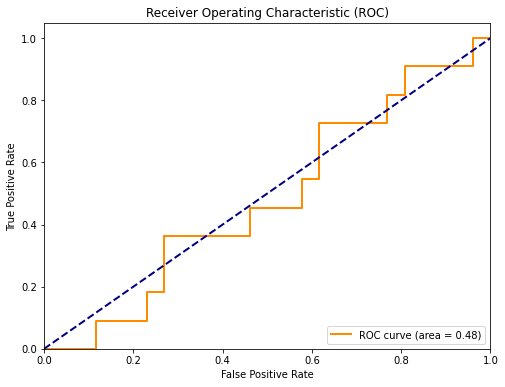

In [51]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from scipy.special import expit  # For the logistic (sigmoid) function

# random_state = 0
# random_state = random.randint(0, 100)

# Loop
acc_arr = []
prob_arr = []
iter = 100
for i in range(iter):
    # Separate features (X) and target (y)
    # X = df_merged[numeric_columns]
    X = df_merged.drop(columns=['bids_name', 'rating'])
    y = df_merged['rating'] # 1 if excluded, 0 if included

    for col in X:
        mean = X[col].mean()
        std = X[col].std()
        X[col] = (X[col] - mean) / std

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i) # random_state=0

    X_columns = X.columns.tolist()

    X_train = X_train.drop(columns=[
        "size_x",
        "size_y",
        "size_z",
        "spacing_x",
        "spacing_y",
        "spacing_z",
        "summary_bg_p05", # all zeros
        "qi_1", # almost all zeros
    ])
    train_columns = X_train.columns.tolist()

    X_test = X_test.drop(columns=[
        "size_x",
        "size_y",
        "size_z",
        "spacing_x",
        "spacing_y",
        "spacing_z",
        "summary_bg_p05", # all zeros
        "qi_1", # almost all zeros
    ])

    # Create a Random Forest Regressor or Classifier (for classification tasks)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=i) # random_state=0, bootstrap=True (If False, the whole dataset is used to build each tree.)

    # - CROSS-VALIDATION - #
    # Perform cross-validation
    num_folds = 5  # Number of folds for cross-validation
    scores = cross_val_score(rf_classifier, X_train, y_train, cv=num_folds, scoring='r2')
    # Print the cross-validation scores for each fold
    # print("Cross-Validation R2 Scores:", scores)
    # Calculate the mean and standard deviation of the cross-validation scores
    mean_r2 = scores.mean()
    std_r2 = scores.std()
    # print("Mean R2 Score:", mean_r2)
    # print("Standard Deviation of R2 Score:", std_r2)
    # ------------------- #

    # - TRAIN THE MODEL - #
    # Fit the model to the training data. Train the model
    rf_classifier.fit(X_train, y_train)
    # ------------------- #

    # - FEATURE IMPORTANCE - #
    # Get feature importances
    feature_importances = rf_classifier.feature_importances_
    # Create a DataFrame to better visualize feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    # Display the sorted feature importances
    # print(feature_importance_df)
    # ---------------------- #

    # -EVALUATE THE MODEL - #
    # Make predictions
    y_pred_test = rf_classifier.predict(X_test)
    # Get predicted probabilities
    y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities of the positive class = excluded (1)
    prob_arr.append(y_pred_prob)
    # print("Probabilities of being class 1 (excluded):", y_pred_prob)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_test)
    acc_arr.append(accuracy)
    confusion = confusion_matrix(y_test, y_pred_test)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion)
    # --------------------- #

avg_acc = np.mean(acc_arr)
avg_prob = np.mean(prob_arr, axis=0)
print('Mean accuracy: ', avg_acc)
print('Mean probs: ', avg_prob)

# - PLOT PREDICTED VS ACTUAL VALUES - #
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, avg_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Large scale testing

probabilities + threshold

In [31]:
y_scores = rf_classifier.predict_proba(df_ls[train_columns])[:, 1] # 1 for excluded according to the model training

In [47]:
# how many values > 0.5 from y_scores
threshold = 0.56
count = (y_scores > threshold).sum()
print(count)

135


In [49]:
# indices of values > threshold from y_scores
y_pred_idx = (y_scores > threshold).nonzero()[0]

In [50]:
# Create a DataFrame to better visualize the predictions
df_predictions_classifier = pd.DataFrame({'subject_name': df_ls['name'], 'bids_name': df_ls['bids_name'], 'pred_rating': y_scores})
# print(df_predictions)
# Look for 0 values in the predictions
excluded = df_predictions_classifier[df_predictions_classifier['pred_rating'] > threshold]
# number of excluded subjects
print(f'excluded subjects: {len(excluded)}/{len(df_predictions_classifier)}')
print(excluded)

excluded subjects: 135/1027
     subject_name    bids_name  pred_rating
18      sub-IXWPL  sub-019_T1w         0.57
35      sub-MEVDI  sub-036_T1w         0.57
40      sub-RCROG  sub-041_T1w         0.57
41      sub-TUBAD  sub-042_T1w         0.57
53      sub-WNMXO  sub-054_T1w         0.57
...           ...          ...          ...
1174    sub-OSABR  sub-964_T1w         0.57
1177    sub-KTHXT  sub-967_T1w         0.57
1186    sub-BBWSL  sub-976_T1w         0.57
1195    sub-ERUZQ  sub-985_T1w         0.57
1201    sub-NIVUA  sub-991_T1w         0.57

[135 rows x 3 columns]


predict

In [19]:
# - INFERENCE - #
# Make predictions
y_pred_test = rf_classifier.predict(df_ls[train_columns])

# Create a DataFrame to better visualize the predictions
df_predictions_classifier = pd.DataFrame({'subject_name': df_ls['name'], 'bids_name': df_ls['bids_name'], 'pred_rating': y_pred_test})
# print(df_predictions)
# Look for 0 values in the predictions
excluded = df_predictions_classifier[df_predictions_classifier['pred_rating'] == 1]
# number of excluded subjects
print(f'excluded subjects: {len(excluded)}/{len(df_predictions_classifier)}')
print(excluded)

excluded subjects: 923/1027
     subject_name    bids_name  pred_rating
1       sub-UPYHV  sub-002_T1w          1.0
4       sub-DVKCK  sub-005_T1w          1.0
5       sub-QAUMU  sub-006_T1w          1.0
6       sub-PANUR  sub-007_T1w          1.0
7       sub-CFPZJ  sub-008_T1w          1.0
...           ...          ...          ...
1203    sub-WXRXV  sub-993_T1w          1.0
1204    sub-GFJAC  sub-994_T1w          1.0
1205    sub-WXFZT  sub-995_T1w          1.0
1206    sub-QPQCV  sub-996_T1w          1.0
1207    sub-CJNZY  sub-997_T1w          1.0

[923 rows x 3 columns]


In [ ]:
# save excluded dataframe to excel
excluded.to_excel('/home/jaimebarranco/Desktop/MRI-QC/excluded_N183_6feat.xlsx', sheet_name='excluded', index=False)

Copy the reports of the excluded subject into a folder

In [ ]:
import shutil

reports_folder = '/home/jaimebarranco/Desktop/MRI-QC/fetal/fetalqc_non-labeled-dataset'
output_folder = '/home/jaimebarranco/Downloads/excluded_N183_6feat'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# copy html reports from reports_folder that match the subjects in excluded dataframe to output_folder
for i in range(len(excluded)):
    subject = excluded['subject_name'].values[i]
    for filename in os.listdir(reports_folder):
        if filename.startswith(f'{subject}_report'):
            shutil.copy(f'{reports_folder}/{filename}', f'{output_folder}/{filename}')